Implementation, testing and training of a Deep Neural Network

In [2]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchmetrics import SymmetricMeanAbsolutePercentageError
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import pickle

Filtering the data and creating the needed features that will be fed into the model

In [3]:
df = pd.read_csv('Data/All_music.csv')
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.drop("Unnamed: 0",inplace=True,axis=1)
df.set_index("timestamp",inplace=True)

df = df["2020-12-14":]

df["dayofweek"] = df.index.dayofweek.astype("int32")
df["log_views"] = np.log(df["views"] + 1e-8)
df["month"] = df.index.month.astype("int32")
df["year"] = df.index.year.astype("int32")
df["avg_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("mean").astype("float64")
df["min_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("min").astype("float64")
df["max_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("max").astype("float64")

for i in range(1, 8):
    df[f"t-{i}"] = df["views"].shift(i).ffill()

df = df.iloc[7:]
features = ["dayofweek", "month", "year", "min_by_song_month", "max_by_song_month", "avg_by_song_month","log_views", "t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7"]
target = "views"

In [4]:
class MusicDataset(Dataset):
    def __init__(self,features,target):
        self.feature = features
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

Creating the training and testing data

In [5]:
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train, test = train_test_split(df, test_size=0.2, shuffle=True)

train_x = torch.tensor(train[features].values).to(device)
train_y = torch.tensor(train[target].values).unsqueeze(1).to(device)
test_x = torch.tensor(test[features].values).to(device)
test_y = torch.tensor(test[target].values).unsqueeze(1).to(device)

train = MusicDataset(train_x,train_y)
valid = MusicDataset(test_x,test_y)

train_loader = DataLoader(train,batch_size=2,shuffle=False)
valid_loader = DataLoader(valid,batch_size=2,shuffle=False)

The first version of the Neural Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.activ1 = nn.LeakyReLU()
        self.hidden2 = nn.Linear(hidden_dim, 1)
        self.activ2 = nn.LeakyReLU()
        self.hidden3 = nn.Linear(hidden_dim - 5, 1)
       
    def forward(self, x):
        x = self.hidden1(x)
        x = self.activ1(x)
        x = self.hidden2(x)
        x = self.activ2(x)
        x = self.hidden3(x)
        return x


def smape(target, forecast):
  if type(target) == pd.core.frame.DataFrame:
    target = target.values

  denominator = np.abs(target) + np.abs(forecast)
  flag = denominator == 0.

  smape = 2 * np.mean(
      (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
  )
  return smape

Training the model

In [23]:
def train_model(train_dl, model):
    # define the optimization
    criterion = SymmetricMeanAbsolutePercentageError().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00047841723492162016)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        running_loss = 0
        for i, (inputs, targets) in enumerate(train_dl):
            #Decay Learning Rate
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs.float().to(device)).to(device)
            # calculate loss
            loss = criterion(yhat.float(), targets.float()).to(device)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

# evaluate the model
def evaluate_model(test_dl, model,epoch = None):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_dl):
            # evaluate the model on the test set
            yhat = model(inputs.float()).to(device)
            # retrieve numpy array
            yhat = yhat.cpu().detach().numpy()
            actual = targets.cpu().detach().numpy()
            actual = actual.reshape((len(actual), 1))
            # round to class values
            yhat = yhat.round()
            # store
            predictions.append(yhat)
            actuals.append(actual)
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    return smape(actuals, predictions)


# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = torch.Tensor([row]).to(device)
    # make prediction
    yhat = model(row).to(device)
    # retrieve numpy array
    yhat = yhat.cpu().detach().numpy()
    return yhat

n_input = len(features)
n_hidden = 20

model = NeuralNetwork(n_input,n_hidden).to(device)
#train_model(train_loader,model) Uncomment to train
path = "DNN_optimized.pth"
#torch.save(model.state_dict(),path)

Generating a more optimal model and storing using optuna

In [11]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np


EPOCHS = 100


# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers = []

    in_features = len(features)
    
    for i in range(n_layers):
        
        out_features = trial.suggest_int("n_units_l{}".format(i), 6, 22)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        p = trial.suggest_float("dropout_l{}".format(i),0.1,0.5) # dropout ratio in each layer
        layers.append(nn.Dropout(p))
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.LeakyReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    

    train, test = train_test_split(df, test_size=0.2, shuffle=True)

    train_x = torch.tensor(train[features].values)
    train_y = torch.tensor(train[target].values).unsqueeze(1)
    test_x = torch.tensor(test[features].values)
    test_y = torch.tensor(test[target].values).unsqueeze(1)

    train = MusicDataset(train_x,train_y)
    valid = MusicDataset(test_x,test_y)

    train_loader = DataLoader(train,batch_size=2,shuffle=False)
    valid_loader = DataLoader(valid,batch_size=2,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = SymmetricMeanAbsolutePercentageError()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in valid_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.float())
                    total_loss_val += batch_loss.item()
                    

            
            accuracy = total_loss_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
     model = build_model_custom(trial)

     accuracy = train_and_evaluate(params, model, trial)
     trial.set_user_attr(key="best_model", value=model)
     return accuracy
  

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])
    

In [ ]:
# study = optuna.create_study(direction="minimize", pruner=optuna.pruners.SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=100,callbacks=[callback])

# with open("DNN_optuna.pkl", "wb") as fout:
#     pickle.dump(study, fout)
# torch.save(best_model.state_dict(),"DNN_optimized.pth")

Evaluting the model

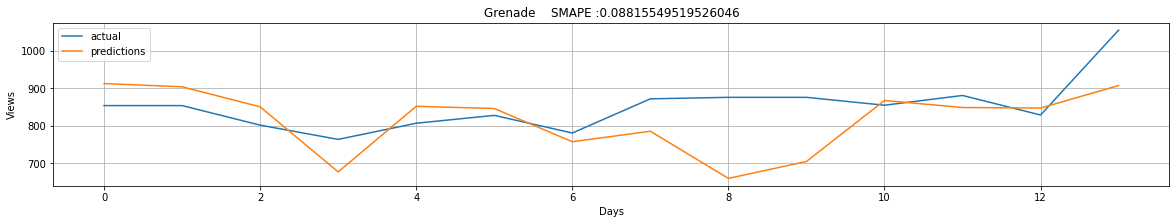

In [117]:
study = pd.read_pickle("DNN_optuna.pkl")
best_model = study.user_attrs["best_model"]

random_song = np.random.choice(df["article"].unique())

song = df[df["article"] == random_song][features][-14:].values
actual = df[df["article"] == random_song][target][-14:].values.flatten()
predicitons = np.zeros(len(song))
for i,v in enumerate(song):
    predicitons[i] = predict(v,best_model)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(actual,label="actual")
plt.plot(predicitons.flatten(),label="predictions")
plt.title(random_song + "    SMAPE :" + str(smape(actual,predicitons.flatten())))
plt.xlabel("Days")
plt.ylabel("Views")
plt.grid()
plt.legend()